<a href="https://colab.research.google.com/github/JoyeBright/Cloud-Computing/blob/master/NMT_S2S_Attention_Per_Eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Hardware spec.**

In [1]:
!cat /proc/cpuinfo
!cat /proc/meminfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

## **Import headers**

In [60]:
import tensorflow as tf

import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import numpy as np
import unicodedata
import re
import io

In [3]:
!pip install hazm

In [4]:
from __future__ import unicode_literals
from hazm import *

## **Mount corpora**

In [5]:
file_path = '/content/drive/MyDrive/Multilingual_Multimodal_Unversal_MT/Parallel Corpora/Per-Eng/manythings/pes-eng/pes.txt'

## **Preprocessing**

In [6]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn') 

def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip()) # lowercase
  w = re.sub(r"([?.!,¿])", r" \1 ", w) # creating a space between every word and punctuation
  w = re.sub(r'[" "]+', " ", w)
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w) # replacing every word with space except those defined

  w = w.strip() # remove space from beginning and end of string
  w = '<start> '+ w + ' <end>' # later model needs this to know where to start and stop

  return w

def preprocess_per_sentence(w):
  normalizer = Normalizer() # Persian normalizer instance (Hazm)
  normalizer.normalize(w)
  w = unicode_to_ascii(w.lower().strip()) # lowercase
  w = re.sub(r'[" "]+', " ", w)
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = '<start> '+ w + ' <end>'

  return w


## **An example**

In [7]:
eng_sentence = "You have beautiful hands."
per_sentence ="تو دستهای زیبایی داری."


print(preprocess_sentence(eng_sentence))
print(preprocess_per_sentence(per_sentence))

<start> you have beautiful hands . <end>
<start> تو دستهای زیبایی داری .  <end>


## **Create a dataset (word pair) from corpus**

In [8]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding="UTF-8").read().strip().split('\n')
  word_pairs = [[preprocess_per_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs) # zip used for parallel iteration

In [9]:
en, per, info = create_dataset(file_path, None) # info is an explanation which included in the corpus

In [10]:
print(en[-3])
print(per[-3])
print(info[-3])

<start> the difference between the right word and almost the right word is the difference between lightning and the lightning bug .  <end>
<start> تفاوت بین کلمه صحیح و کلمه تقریبا صحیح مانند تفاوت بین مهتاب و کرم شب‌تاب است .  <end>
<start> cc-by 2 . 0 (france) attribution: tatoeba . org #667975 (ck) & #7525272 (cojiluc) <end>


In [11]:
def tokenize(lang):
  language_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '')
  
  # Creating the vocabulary index based on word frequency.
  # 0 is a reserved index that won't be assigned to any word
  language_tokenizer.fit_on_texts(lang) 

  # Transforming each text in texts to a sequence of integers
  tensor = language_tokenizer.texts_to_sequences(lang) 

  # pads the sequences to the same length.
  # seq = [[1], [2, 3], [4, 5, 6]]
  # post-padding
  # array([[1, 0, 0],
  #          [2, 3, 0],
  #          [4, 5, 6]])
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
  
  return tensor, language_tokenizer

In [12]:
def load_dataset(path, number_examples = None):
  target_language, source_language, info = create_dataset(path, number_examples)

  source_tensor, source_lang_tokenize = tokenize(source_language)
  target_tensor, target_lang_tokenize = tokenize(target_language)

  return source_tensor, target_tensor, source_lang_tokenize, target_lang_tokenize, info

**Limit/ control the size of dataset to experiment faster**

In [13]:
number_examples = 2270 # var
source_tensor, target_tensor, source_lang, target_lang, info = load_dataset(file_path, number_examples)


In [14]:
# Calculating max_length of the source and target tensors
max_length_target, max_length_source = target_tensor.shape[1], source_tensor.shape[1]

# Using sklearn to creat training and validation sets: 80-20 split
source_tensor_train, source_tensor_val, target_tensor_train, target_tensor_val = train_test_split(source_tensor, target_tensor, test_size = 0.2)

In [15]:
# Print info up to here
print(" training size of source (Per): ", len(source_tensor_train),"\n", "training size of target (Eng): ", len(target_tensor_train), "\n", "validation size of source (Per): ", len(source_tensor_val), "\n", "validation size of target (Eng): ", len(target_tensor_val))

 training size of source (Per):  1816 
 training size of target (Eng):  1816 
 validation size of source (Per):  454 
 validation size of target (Eng):  454


### **Finding the word from their indices or vice versa (word-index dictionary)**

In [16]:
def convert(language, tensor):
  for t in tensor:
    if t!=0:
      print("%d ––––––> %s" % (t, language.index_word[t]))

In [17]:
print("mapping source language: index to word")
convert(source_lang, source_tensor_train[0])
print("")
print("mapping target language: index to word")
convert(target_lang, target_tensor_train[0])

mapping source language: index to word
1 ––––––> <start>
10 ––––––> تام
23 ––––––> برای
91 ––––––> بیرون
469 ––––––> ماندن
13 ––––––> در
76 ––––––> تمام
3239 ––––––> شب،
47 ––––––> ماری
5 ––––––> را
1415 ––––––> سرزنش
18 ––––––> کرد
3 ––––––> .
2 ––––––> <end>

mapping target language: index to word
1 ––––––> <start>
11 ––––––> tom
1129 ––––––> chewed
56 ––––––> mary
76 ––––––> out
22 ––––––> for
452 ––––––> staying
76 ––––––> out
41 ––––––> all
138 ––––––> night
143 ––––––> long
3 ––––––> .
2 ––––––> <end>


## **Dataset preparation for Tensorflow**


In [18]:
#Hyperparameters
BATCH_SIZE = 64
steps_per_epoch = len(source_tensor_train) // BATCH_SIZE
embedding_dimension = 256
units = 1024
BUFFER_SIZE = len(source_tensor_train)
vocabulary_source_size = len(source_lang.word_index) + 1
vocabulary_target_size = len(target_lang.word_index) + 1

print("Persian vocabulary size: ", vocabulary_source_size)
print("English vocabulary size: ", vocabulary_target_size)

Persian vocabulary size:  3710
English vocabulary size:  2564


In [19]:
# Keras models accept three types of inputs: Numpy array, TF dataset objects(sth I used here), and Python generators
dataset = tf.data.Dataset.from_tensor_slices((source_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
# drop_remainder ignores the last batch
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

### **An example**

In [20]:
example_source_batch, example_target_batch = next(iter(dataset))
example_source_batch.shape, example_target_batch.shape

(TensorShape([64, 27]), TensorShape([64, 25]))

## **Designing encoder and decoder model with attention**

## **Encoder**
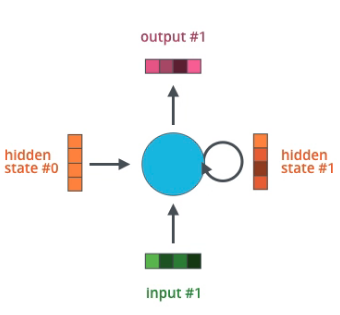

In [21]:
# ENCODER:
# Embedding layer (1)
# GRU layer (2)
# First hidden layer shape is: [batch_size, number of neurons]
# Second or output layer shape is: [batch_size, max_length, number of neurons]
#..................................................................
class Encoder(tf.keras.Model):
  def __init__(self, vocabulary_size, embedding_dimension, encoder_units, batch_size):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.encoder_units = encoder_units
    self.embedding = tf.keras.layers.Embedding(vocabulary_size, embedding_dimension)
    self.gru = tf.keras.layers.GRU(self.encoder_units, 
                                              return_sequences=True,
                                              return_state=True,
                                              recurrent_initializer='glorot_uniform') # default: orthogonal
  
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state
  

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_size, self.encoder_units))

In [22]:
encoder = Encoder(vocabulary_source_size, embedding_dimension, units, BATCH_SIZE)

### **An example of encoder**

In [23]:
# Sample
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_source_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 27, 1024)
Encoder hidden state shape: (batch size, units) (64, 1024)


### **Attention Mechanism**

Notes regarding attention mechanism:
1.   First, the encoder passes a lot more data to the decoder. Instead of passing the last hidden state of the encoding stage, the encoder passes all the hidden states to the decoder
2.   Second, an attention decoder does an extra step before producing its output.

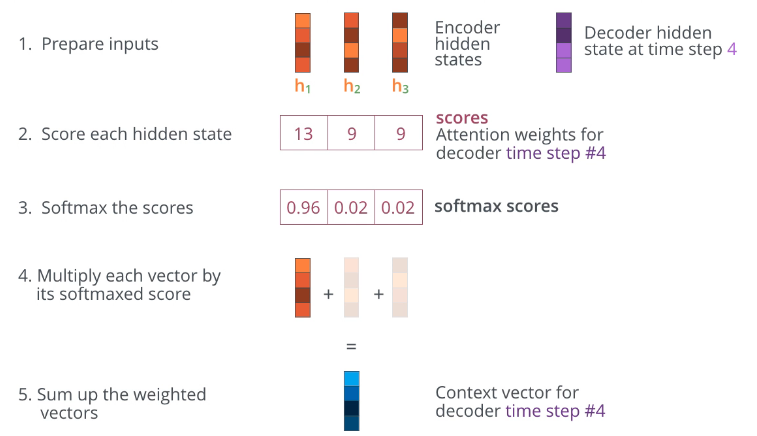

In [24]:
class Attention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values): # values = encoder_outputs
    query_with_time_axis = tf.expand_dims(query, 1) # Returns a tensor with a length 1 axis inserted at index axis
    
    # FC = Fully connected (dense) layer
    # score = FC (tanh(FC(EO) + FC(H)))
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
    
    # attention weights = softmax(score, axis = 1)
    attention_weights = tf.nn.softmax(score, axis = 1)
    
    # context vector = sum(attention weights * Encoder_output, axis = 1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis = 1) #Computes the sum of elements across dimensions of a tensor.

    return context_vector, attention_weights

**An example of attention**

In [25]:
attention_layer = Attention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 27, 1)


## **Decoder**

In [26]:
class Decoder(tf.keras.Model):
  def __init__(self, vocabulary_size, embedding_dim, decoder_units, batch_size):
    super(Decoder, self).__init__()
    self.batch_size = batch_size
    self.decoder_units = decoder_units
    self.embedding = tf.keras.layers.Embedding(vocabulary_size, embedding_dimension)
    self.gru = tf.keras.layers.GRU(self.decoder_units, return_sequences = True, return_state = True, recurrent_initializer = 'glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocabulary_size)
    self.attention  = Attention(self.decoder_units)

  def call(self, x, hidden, encoder_output):
    context_vector, attention_weights = self.attention(hidden, encoder_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)

    return x, state, attention_weights

In [27]:
decoder = Decoder(vocabulary_target_size, embedding_dimension, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2564)


### **Optimizing model in Keras**

In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, prediction):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, prediction)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### **Implementing checkpoints to save the model and resume fitting**

In [29]:
import os

In [30]:
checkpoint_dir = '/content/drive/MyDrive/Multilingual_Multimodal_Unversal_MT/Parallel Corpora/Per-Eng/manythings/Training-Checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## **Training**

In [31]:
@tf.function
def train_step(input, target, encoder_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    encoder_output, encoder_hidden = encoder(input, encoder_hidden)
    decoder_hidden = encoder_hidden
    decoder_input = tf.expand_dims([target_lang.word_index['<start>']] * BATCH_SIZE, 1)
    for t in range(1, target.shape[1]):
      predictions, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_output)
      loss += loss_function(target[:,  t], predictions)
      decoder_input = tf.expand_dims(target[:, t], 1)
  batch_loss = (loss / int(target.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [32]:
EPOCHS = 40
import time

In [33]:
for epoch in range(EPOCHS):
  start = time.time()

  encoder_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for(batch, (input, target)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(input, target, encoder_hidden)
    total_loss += batch_loss

    if batch % 100 ==0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    
  # save checkpoint the model after 20 epochs
  if (epoch + 1) % 20 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.7716
Epoch 1 Loss 2.1518
Time taken for 1 epoch 46.19812512397766 sec

Epoch 2 Batch 0 Loss 1.8783
Epoch 2 Loss 1.7932
Time taken for 1 epoch 12.286036491394043 sec

Epoch 3 Batch 0 Loss 1.5418
Epoch 3 Loss 1.6863
Time taken for 1 epoch 12.269570112228394 sec

Epoch 4 Batch 0 Loss 1.6399
Epoch 4 Loss 1.5931
Time taken for 1 epoch 12.221363544464111 sec

Epoch 5 Batch 0 Loss 1.5413
Epoch 5 Loss 1.5101
Time taken for 1 epoch 12.199315786361694 sec

Epoch 6 Batch 0 Loss 1.5493
Epoch 6 Loss 1.4413
Time taken for 1 epoch 12.24128246307373 sec

Epoch 7 Batch 0 Loss 1.5028
Epoch 7 Loss 1.3720
Time taken for 1 epoch 12.19942045211792 sec

Epoch 8 Batch 0 Loss 1.2650
Epoch 8 Loss 1.3101
Time taken for 1 epoch 12.221567392349243 sec

Epoch 9 Batch 0 Loss 1.1616
Epoch 9 Loss 1.2497
Time taken for 1 epoch 12.218627214431763 sec

Epoch 10 Batch 0 Loss 1.2147
Epoch 10 Loss 1.1871
Time taken for 1 epoch 12.193275690078735 sec

Epoch 11 Batch 0 Loss 1.0809
Epoch 11 Loss 1.1291
T

## **Translation and Testing the model**

In [97]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_target, max_length_source))

  sentence = preprocess_per_sentence(sentence)

  inputs = [source_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], 
                                                         maxlen=max_length_source, 
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)
  result = ''
  hidden = [tf.zeros((1, units))]
  encoder_out, encoder_hidden = encoder(inputs, hidden)
  decoder_hidden = encoder_hidden
  decoder_input = tf.expand_dims([target_lang.word_index['<start>']], 0)

  for t in range(max_length_target):
    predictions, decoder_hidden, attention_weights = decoder(decoder_input, decoder_hidden, encoder_out)
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += target_lang.index_word[predicted_id] + ' '

    if target_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    decoder_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

### **Plot the attention weights**

In [98]:
import matplotlib.pyplot as plt

In [123]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='inferno')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

**Translation**

In [100]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### **Restore the checkpoints and test the model**

In [101]:
#checkpoint directory declared before
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

**First attempt**

Input: <start> بیا تلویزیون ببینیم <end>
Predicted translation: let's watch tv . <end> 


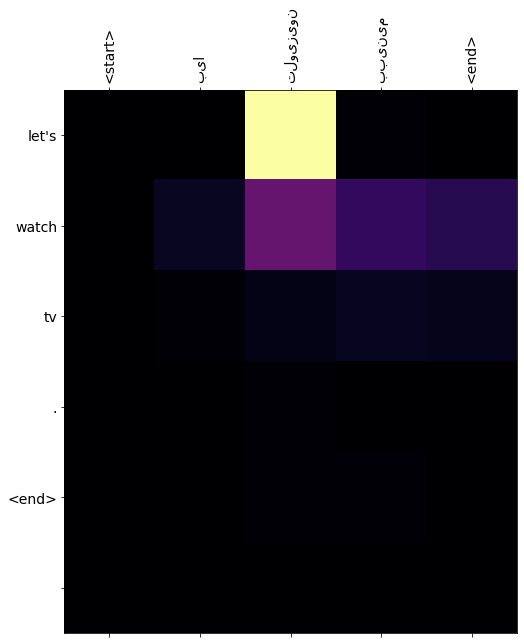

In [124]:
translate('بیا تلویزیون ببینیم')

**Second attempt**

Input: <start> زندگی مثل دوچرخه سواری است برای حفظ تعادل باید در حرکت باشید <end>
Predicted translation: being , it's like riding a bicycle . <end> 


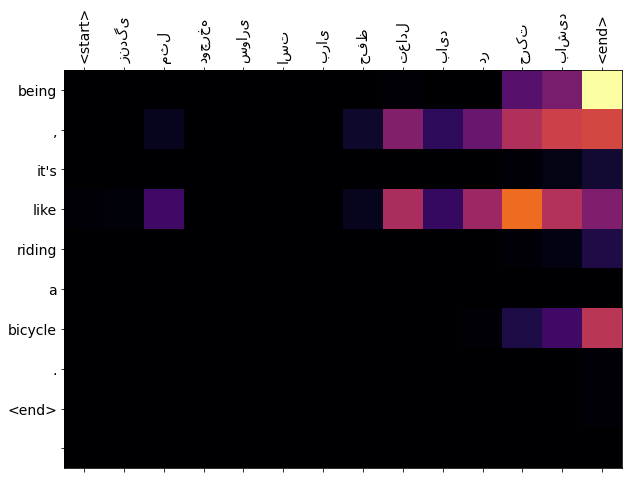

In [125]:
translate('زندگی مثل دوچرخه سواری است برای حفظ تعادل باید در حرکت باشید')